# Synthetic Data Vault (SDV)

The Synthetic Data Vault (SDV) is a Python library designed to be your one-stop shop for creating tabular synthetic data. The SDV uses a variety of machine learning algorithms to learn patterns from your real data and emulate them in synthetic data.

The SDV offers multiple models, ranging from classical statistical methods (GaussianCopula) to deep learning methods (CTGAN). Generate data for single tables, multiple connected tables or sequential tables.


In [ ]:
%pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

## Load and reshape lipidomics data and the lipid metadata

In [ ]:
import pandas as pd

# Load metadata datasets
lipid_meta_df = pd.read_csv("lipid_metadata.csv")
lipidomics_df = pd.read_csv("lipidomics.csv")

# Map lipid feature names (excluding 'Group') to numeric IDs
lipid_columns = [col for col in lipidomics_df.columns if col != 'Group']
lipid_id_map = {orig: idx for idx, orig in enumerate(lipid_columns)}

# Rename columns and reshape lipidomics to long format
renamed_lipidomics_df = lipidomics_df.rename(columns=lipid_id_map)

long_df = renamed_lipidomics_df.melt(
    id_vars="Group",
    var_name="lipid_id",
    value_name="concentration"
).reset_index().rename(columns={"index": "sample_id"})

long_df['lipid_id'] = long_df['lipid_id'].astype(int)

# Apply the same numeric lipid_id mapping to lipid metadata
lipid_meta_df = lipid_meta_df[lipid_meta_df["ID"].isin(lipid_id_map.keys())].copy()
lipid_meta_df["lipid_id"] = lipid_meta_df["ID"].map(lipid_id_map).astype(int)
lipid_meta_df = lipid_meta_df.drop(columns=["ID"])

In [ ]:
from sklearn.preprocessing import QuantileTransformer


qt = QuantileTransformer(output_distribution='uniform')
long_df['concentration'] = qt.fit_transform(long_df[['concentration']])
long_df

,sample_id,Group,lipid_id,concentration
0,0,C,0,0.958256
1,1,C,0,0.920472
2,2,A,0,0.753806
3,3,A,0,0.618415
4,4,A,0,0.271048
...,...,...,...,...
313219,313219,B,2525,0.040740
313220,313220,C,2525,0.048106
313221,313221,C,2525,0.177372
313222,313222,D,2525,0.403250


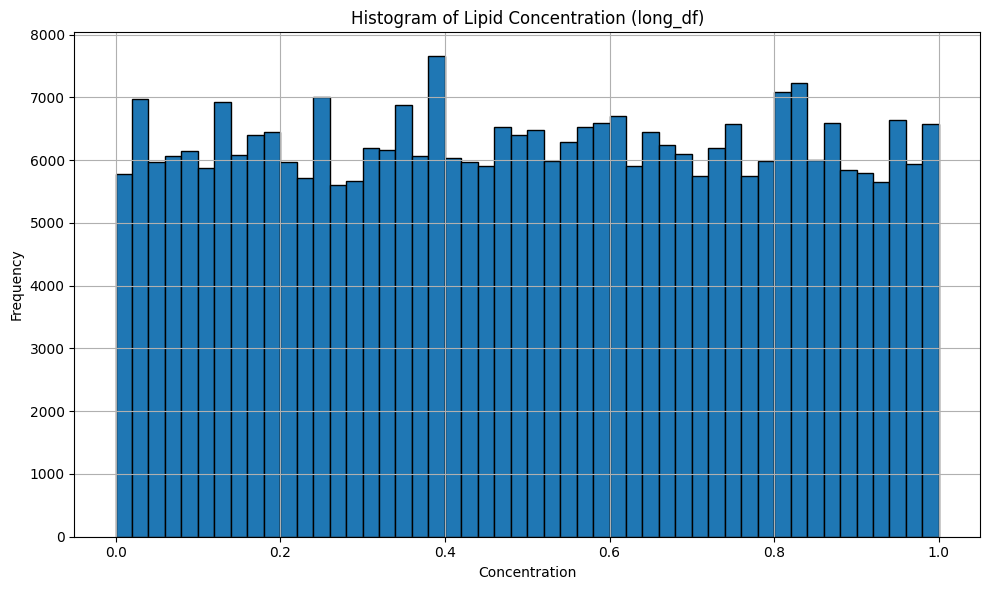

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for the 'concentration' feature
plt.figure(figsize=(10, 6))
plt.hist(long_df['concentration'], bins=50, edgecolor='black')
plt.title('Histogram of Lipid Concentration (long_df)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(long_df['concentration'].describe())
print(long_df['concentration'].nunique())

count    313224.000000
mean          1.075438
std           0.612291
min           0.008912
25%           0.781737
50%           1.000185
75%           1.244612
max          99.711286
Name: concentration, dtype: float64
313102


In [ ]:
long_df.head()

,sample_id,Group,lipid_id,concentration
0,0,C,0,0.958256
1,1,C,0,0.920472
2,2,A,0,0.753806
3,3,A,0,0.618415
4,4,A,0,0.271048


In [ ]:
long_df.shape # 124 samples times 2526 lipid features

(313224, 4)

In [ ]:
lipid_meta_df.head()

,RT (min),m/z,Polarity,Identification Level,best_match,m/z error (ppm),MS/MS score (Tiers 1 or 2),Subclass,Other Possibilities,lipid_id
0,0.573128,420.332794,Pos,Tier 3,NAE 20:0;O4,1.977461,NaN,NAE,NaN,0
1,0.889827,646.396606,Pos,Tier 3,LPI 20:0,6.390258,NaN,LPI,ST 28:4;O4;HexNAc | ST 28:3;O5;HexNAc | LPI O-...,1
2,0.902684,752.450195,Pos,Tier 3,PC 30:4;O2,3.962241,NaN,PC,PS 32:3 | PS O-32:4;O,2
3,0.915819,498.310852,Pos,Tier 3,ST 24:1;O7;G,9.465245,NaN,ST,ST 18:0;O3;HexNAc | ST 24:0;O8;G | Car 19:4;O4,3
4,0.914509,513.320801,Pos,Tier 3,LPG 18:0,4.102566,NaN,LPG,LPG O-18:1;O,4


In [ ]:
lipid_meta_df.shape

(2526, 10)

## Define metadata for MultiTable modeling

In [ ]:
import json

multi_table_metadata = {
    "tables": {
        "lipids": {
            "primary_key": "lipid_id",
            "columns": {
                "lipid_id": {"sdtype": "id"},
                "RT (min)": {"sdtype": "numerical"},
                "m/z": {"sdtype": "numerical"},
                "Polarity": {"sdtype": "categorical"},
                "Identification Level": {"sdtype": "categorical"},
                "best_match": {"sdtype": "categorical"},
                "m/z error (ppm)": {"sdtype": "numerical"},
                "MS/MS score (Tiers 1 or 2)": {"sdtype": "numerical"},
                "Subclass": {"sdtype": "categorical"},
                "Other Possibilities": {"sdtype": "categorical"}
            }
        },
        "samples": {
            "columns": {
                "sample_id": {"sdtype": "id"},
                "lipid_id": {"sdtype": "id"},
                "concentration": {"sdtype": "numerical"},
                "Group": {"sdtype": "categorical"}
            }
        }
    },
    "relationships": [
        {
            "parent_table_name": "lipids",
            "parent_primary_key": "lipid_id",
            "child_table_name": "samples",
            "child_foreign_key": "lipid_id"
        }
    ]
}


with open("multi_table_metadata.json", "w") as f:
    json.dump(multi_table_metadata, f, indent=4)


## Convert dict to MultiTableMetadata

In [ ]:
from sdv.metadata import MultiTableMetadata

# Convert the dictionary to a MultiTableMetadata object
metadata_obj = MultiTableMetadata.load_from_dict(multi_table_metadata)

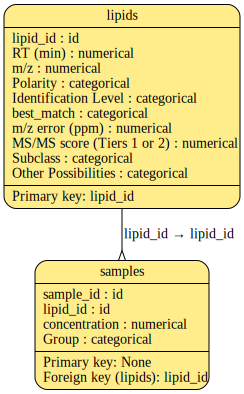

In [ ]:
metadata_obj.visualize()

## Train SDV MultiTable Model

In [ ]:
from sdv.multi_table import HMASynthesizer
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer

synthesizer = HMASynthesizer(metadata=metadata_obj)

synthesizer.fit({
    "lipids": lipid_meta_df,
    "samples": long_df
})


/usr/local/lib/python3.11/dist-packages/sdv/multi_table/base.py:109: FutureWarning: The 'MultiTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
Preprocess Tables: 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]



Learning relationships:


(1/1) Tables 'lipids' and 'samples' ('lipid_id'): 100%|██████████| 2526/2526 [04:53<00:00,  8.60it/s]


Modeling Tables: 100%|██████████| 2/2 [00:12<00:00,  6.08s/it]


## Generate synthetic samples

In [ ]:
synthetic_data = synthesizer.sample()

synthetic_lipids = synthetic_data["lipids"]
synthetic_samples = synthetic_data["samples"]


In [ ]:
synthetic_lipids.head()

,lipid_id,RT (min),m/z,Polarity,Identification Level,best_match,m/z error (ppm),MS/MS score (Tiers 1 or 2),Subclass,Other Possibilities
0,12995570,14.159926,882.244884,Pos,Tier 3,PIP3 44:10,0.121332,NaN,TG,NaN
1,14274727,12.205415,607.350950,Pos,Tier 1,PC O-44:6,2.787164,NaN,TG,NaN
2,7155943,13.390526,915.341567,Pos,Tier 3,PIP3 47:9,0.481222,597.432036,HexCer,HexCer 37:4;O2 | ACer 43:4;O6
3,10401667,6.489616,988.547037,Neg,Tier 1,TG 64:9,0.149017,NaN,SM,NaN
4,5039473,12.027242,1021.289183,Neg,Tier 3,TG 15:0_21:0_21:3,2.291159,NaN,HexCer,PS O-44:6


In [ ]:
synthetic_samples.head()

,sample_id,lipid_id,concentration,Group
0,2498094,12995570,0.0,D
1,9665662,12995570,0.0,D
2,15556948,12995570,0.0,D
3,8593642,12995570,0.0,A
4,3921261,12995570,0.0,C


## Evaluating Real vs. Synthetic Data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a diagnostic to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

1. All primary keys must be unique
2. Continuous values must adhere to the min/max of the real data
3. Discrete columns (non-PII) must have the same categories as the real data
Etc.

In [ ]:
from sdv.evaluation.multi_table import run_diagnostic

real_data = {}
real_data['lipids'] = lipid_meta_df
real_data['samples'] = long_df

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata_obj
)

Generating report ...

(1/3) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 165.17it/s]|
Data Validity Score: 100.0%

(2/3) Evaluating Data Structure: |██████████| 2/2 [00:00<00:00, 266.47it/s]|
Data Structure Score: 100.0%

(3/3) Evaluating Relationship Validity: |██████████| 1/1 [00:00<00:00, 64.63it/s]|
Relationship Validity Score: 100.0%

Overall Score (Average): 100.0%



We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [ ]:
from sdv.evaluation.multi_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata_obj
)

Generating report ...

(1/4) Evaluating Column Shapes: |██████████| 14/14 [00:00<00:00, 45.44it/s]|
Column Shapes Score: 84.51%

(2/4) Evaluating Column Pair Trends: |██████████| 51/51 [00:00<00:00, 113.89it/s]|
Column Pair Trends Score: 64.77%

(3/4) Evaluating Cardinality: |██████████| 1/1 [00:00<00:00, 55.42it/s]|
Cardinality Score: 100.0%

(4/4) Evaluating Intertable Trends: |██████████| 40/40 [00:02<00:00, 19.96it/s]|
Intertable Trends Score: 66.35%

Overall Score (Average): 78.9%



According to the score, the synthetic data is about 75% similar to the real data in terms of statistical similarity.

In [ ]:
quality_report.get_details('Column Shapes')

,Table,Column,Metric,Score
0,lipids,RT (min),KSComplement,0.924386
1,lipids,m/z,KSComplement,0.927949
2,lipids,Polarity,TVComplement,0.991291
3,lipids,Identification Level,TVComplement,0.996833
4,lipids,best_match,TVComplement,0.670625
5,lipids,m/z error (ppm),KSComplement,0.941805
6,lipids,MS/MS score (Tiers 1 or 2),KSComplement,0.888295
7,lipids,Subclass,TVComplement,0.956856
8,lipids,Other Possibilities,TVComplement,0.658101
9,samples,concentration,KSComplement,0.396681


In [ ]:
synthetic_samples['concentration'].unique()

array([0.        , 1.        , 0.57530341, 0.5749375 , 0.57523859,
       0.57480754, 0.57456626, 0.57551661, 0.57492357, 0.57454647,
       0.57478704, 0.5746196 , 0.57445591, 0.5742898 , 0.5755577 ,
       0.57454455, 0.57438924, 0.57435394, 0.57470455, 0.5754247 ,
       0.57422319, 0.57492506, 0.57417716, 0.57513839, 0.57455779,
       0.57497815, 0.57451412, 0.57470356, 0.5747849 , 0.57443327,
       0.57420755, 0.57474411, 0.57520367, 0.57392659, 0.57401193,
       0.57443104, 0.57460129, 0.57413094, 0.57443808, 0.57374844,
       0.5751605 , 0.57514467, 0.57544414, 0.57478318, 0.57427087,
       0.57433364, 0.57471572, 0.57487495, 0.57447837, 0.57576704,
       0.57450905, 0.57438786, 0.5744761 , 0.57387958, 0.57503152,
       0.57481481, 0.57532159, 0.57408312, 0.5752977 , 0.57504383,
       0.57501737, 0.57365356, 0.57454147, 0.57494541, 0.57530073,
       0.57452246, 0.57579522, 0.57509366, 0.5744278 , 0.5748929 ,
       0.57476403, 0.57514084, 0.57454309, 0.57445911, 0.57486

The SDV model to synthesize lipidomics data appears to be overfitting to maximum values, especially for concentration features, which isn't uncommon with high-dimensional bioscience datasets.

Generative models like those in SDV can "collapse" to repeating extremes (like maximum values) if they struggle to learn the underlying distributions, particularly in sparse or high-dimensional settings.

In [ ]:
# Inverse-transform synthetic data
synthetic_samples['concentration'] = qt.inverse_transform(synthetic_samples[['concentration']])
synthetic_samples

,sample_id,lipid_id,concentration,Group
0,2498094,12995570,0.014382,D
1,9665662,12995570,0.014382,D
2,15556948,12995570,0.014382,D
3,8593642,12995570,0.014382,A
4,3921261,12995570,0.014382,C
...,...,...,...,...
313219,4538857,11663573,40.428612,C
313220,8385851,11663573,40.428612,D
313221,7942640,11663573,40.428612,C
313222,7177436,11663573,40.428612,B


I tried:
1. Removing oulier samples (still overfitting to max concentration value 5)
2. Quantile transforming (normal and uniform) the concentrations (overfits to min/max values)

# CTGAN

In [ ]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd

# Step 2: Define table metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=real_data['samples'])

# Manually adjust types to match your schema
metadata.update_column(column_name='sample_id', sdtype='id')
metadata.update_column(column_name='lipid_id', sdtype='id')
metadata.update_column(column_name='concentration', sdtype='numerical')
metadata.update_column(column_name='Group', sdtype='categorical')

# Step 3: Fit the CTGAN model
synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(real_data['samples'])

# Step 4: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)  # or len(df) to match size

# Step 5 (optional): Save synthetic data
#synthetic_data.to_csv('synthetic_lipid_data.csv', index=False)

# Step 6 (optional): Evaluate
synthesizer.get_info()


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


{'class_name': 'CTGANSynthesizer',
 'creation_date': '2025-03-26',
 'is_fit': True,
 'last_fit_date': '2025-03-26',
 'fitted_sdv_version': '1.19.0'}

In [ ]:
print(long_df['concentration'].describe())
print(long_df['concentration'].nunique())

count    313224.000000
mean          0.500442
std           0.287828
min           0.000000
25%           0.250749
50%           0.500304
75%           0.749684
max           1.000000
Name: concentration, dtype: float64
313082


## CTGAN on the non-long format

In [ ]:
import pandas as pd

file_name = "lipidomics_tier_3.csv"
df = pd.read_csv(file_name)
df

,Group,1,27,43,62,69,75,82,96,133,...,n|394.0,n|396.0,n|409.0,n|496.0,n|649.0,n|69.0,n|845.0,n|937.0,n|9871.0,n|9958.0
0,C,1.988352,0.847322,0.743314,0.881583,0.690943,0.645797,0.873098,0.681353,0.856537,...,1.024838,0.998547,0.845733,1.287973,0.873782,0.971169,1.557806,1.173375,1.003976,0.618159
1,C,1.679979,1.613443,0.712193,0.691721,1.077915,0.737574,1.218698,0.928635,1.051831,...,1.094357,1.097955,0.749717,0.917493,0.899939,2.262748,1.851385,0.994662,0.492761,1.731347
2,A,1.250552,2.472695,0.953179,1.158781,1.067063,1.071508,0.867627,1.127018,1.009592,...,1.060280,0.778943,0.920818,1.427947,0.901946,0.605246,1.686963,1.093928,2.366880,1.043062
3,A,1.102796,1.716970,0.978330,0.929724,0.800943,0.779628,0.939146,0.771598,0.911730,...,0.827303,0.735320,0.611838,0.498015,0.660157,1.263726,1.421166,0.974586,1.163152,1.156062
4,A,0.801459,3.127969,1.872354,1.351556,1.361572,1.315725,1.052952,1.283985,1.352129,...,0.862190,0.866883,0.733851,0.685565,0.894309,1.633569,0.377153,0.919686,0.105094,0.992380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,B,1.011456,1.059477,0.786341,0.746085,0.755385,0.819435,0.684001,0.943195,0.696801,...,0.996208,1.266113,0.982680,2.444971,1.418911,0.835497,0.951409,1.195288,2.193454,0.338617
120,C,1.905670,0.708112,0.985028,0.797138,0.627481,0.623733,0.652166,0.804747,0.827658,...,0.892505,1.056478,0.907564,0.576873,0.959637,0.582394,1.087298,1.103881,0.692139,0.443309
121,C,1.785563,1.710176,0.652930,1.079087,0.718363,0.842523,0.820787,0.741046,0.975913,...,1.055484,0.935485,0.914516,1.624514,0.970103,0.987560,2.011505,1.013105,1.050490,0.831429
122,D,1.624342,1.508857,0.841347,0.715657,0.502885,0.488357,0.978663,0.575347,0.889602,...,1.109676,0.919650,0.995341,1.082461,1.079213,1.160173,1.546269,0.984107,1.259861,0.264469


In [ ]:
groups = df["Group"]

midpoint = len(df.columns) // 2
print(f"midpoint: {midpoint}")

# Split vertically (along columns)
df_left = df.iloc[:, :midpoint]
df_right = df.iloc[:, midpoint:]
df_right["Group"] = groups

midpoint: 774


In [ ]:
df_left

,Group,1,27,43,62,69,75,82,96,133,...,11932,11933,11968,12015,12105,12158,12161,12163,12171,12204
0,C,1.988352,0.847322,0.743314,0.881583,0.690943,0.645797,0.873098,0.681353,0.856537,...,1.463557,1.360274,0.801852,1.634785,0.874982,0.291821,0.720053,0.378115,0.719250,0.588189
1,C,1.679979,1.613443,0.712193,0.691721,1.077915,0.737574,1.218698,0.928635,1.051831,...,0.677160,1.035715,0.550016,1.458424,0.761842,0.152096,0.764031,0.335810,0.758169,0.526628
2,A,1.250552,2.472695,0.953179,1.158781,1.067063,1.071508,0.867627,1.127018,1.009592,...,0.505184,0.992739,1.057552,0.946540,0.935713,1.248427,1.120846,0.883265,0.443857,1.061970
3,A,1.102796,1.716970,0.978330,0.929724,0.800943,0.779628,0.939146,0.771598,0.911730,...,0.911772,0.876849,0.404426,1.280923,0.907763,2.111119,0.985819,1.402536,0.928283,2.078051
4,A,0.801459,3.127969,1.872354,1.351556,1.361572,1.315725,1.052952,1.283985,1.352129,...,0.966318,0.429589,1.070510,0.529459,0.548390,0.761517,1.159786,1.039235,1.074549,1.232392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,B,1.011456,1.059477,0.786341,0.746085,0.755385,0.819435,0.684001,0.943195,0.696801,...,0.867240,1.338861,1.176865,0.769369,1.005853,0.362593,1.698362,0.379072,1.185572,0.501732
120,C,1.905670,0.708112,0.985028,0.797138,0.627481,0.623733,0.652166,0.804747,0.827658,...,0.839541,0.981658,1.217810,1.214057,0.731053,1.113831,0.804586,0.979545,0.786450,1.005080
121,C,1.785563,1.710176,0.652930,1.079087,0.718363,0.842523,0.820787,0.741046,0.975913,...,0.508255,1.113771,0.620785,0.619366,0.765997,0.519462,0.956256,0.596073,0.557677,0.592233
122,D,1.624342,1.508857,0.841347,0.715657,0.502885,0.488357,0.978663,0.575347,0.889602,...,1.200342,0.880187,0.880369,0.636332,0.948917,0.260146,1.192002,0.360614,0.827217,0.483626


In [ ]:
df_right

,12228,12256,12287,12322,12342,12365,12378,12394,12395,12397,...,n|396.0,n|409.0,n|496.0,n|649.0,n|69.0,n|845.0,n|937.0,n|9871.0,n|9958.0,Group
0,0.305810,0.970174,1.444370,1.000000,0.511066,0.482028,0.913694,0.806393,0.202837,0.731188,...,0.998547,0.845733,1.287973,0.873782,0.971169,1.557806,1.173375,1.003976,0.618159,C
1,0.787734,1.413526,0.724265,0.646230,0.801333,0.619728,0.675343,0.787299,0.441654,0.922978,...,1.097955,0.749717,0.917493,0.899939,2.262748,1.851385,0.994662,0.492761,1.731347,C
2,0.662710,0.589797,1.544394,1.544879,1.152370,1.278141,1.491613,1.022960,2.412724,1.521912,...,0.778943,0.920818,1.427947,0.901946,0.605246,1.686963,1.093928,2.366880,1.043062,A
3,1.192521,2.682429,1.509490,0.956560,1.200637,1.169003,0.959015,1.140665,1.599802,1.070004,...,0.735320,0.611838,0.498015,0.660157,1.263726,1.421166,0.974586,1.163152,1.156062,A
4,0.590273,1.528791,0.886875,1.682034,1.194778,1.200783,0.645519,1.061985,1.247054,1.275505,...,0.866883,0.733851,0.685565,0.894309,1.633569,0.377153,0.919686,0.105094,0.992380,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.492089,0.178631,0.434128,1.097220,0.469399,0.551689,1.957666,1.067842,0.178282,0.945557,...,1.266113,0.982680,2.444971,1.418911,0.835497,0.951409,1.195288,2.193454,0.338617,B
120,0.939604,0.793229,1.232132,0.580132,0.987095,0.880728,1.127695,1.150674,2.032587,1.239971,...,1.056478,0.907564,0.576873,0.959637,0.582394,1.087298,1.103881,0.692139,0.443309,C
121,1.171926,0.254909,0.706600,0.640287,0.852859,0.953932,1.094939,1.106468,0.779115,1.424791,...,0.935485,0.914516,1.624514,0.970103,0.987560,2.011505,1.013105,1.050490,0.831429,C
122,0.572063,0.345225,0.830993,1.635165,0.505840,0.577356,1.625203,0.821883,0.251596,1.000909,...,0.919650,0.995341,1.082461,1.079213,1.160173,1.546269,0.984107,1.259861,0.264469,D


In [ ]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from google.colab import files
import pandas as pd

file_name = "lipidomics_tier_3.csv"
# df = pd.read_csv("lipidomics_tier_1.csv") # 1h to train
# df = pd.read_csv("lipidomics_tier_2.csv") # 5m to train
# df = pd.read_csv(file_name)

meta = SingleTableMetadata()
meta.detect_from_dataframe(data=df_right)

synthesizer = CTGANSynthesizer(meta)
synthesizer.fit(df_right)

synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv(f'SDV_CTGAN_synthetic_{file_name}', index=False)
files.download(f'SDV_CTGAN_synthetic_{file_name}')

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
12228                  11
12256                  11
12287                  11
12322                  11
12342                  11
12365                  11
12378                  11
12394                  11
12395                  11
12397                  11
12399                  11
12412                  11
12415                  11
12458                  11
12474                  11
12515                  11
12520                  11
12522                  11
12525                  11
12562                  11
12567                  11
12575                  11
12594                  11
12610                  11
12611                  11
12617                  11
12631                  11
12639                  11
12643                  11
12644                  11
12645                  11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluating Real vs. Synthetic CTGAN Data

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=meta
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 803/803 [00:00<00:00, 1541.35it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 34.04it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    df,
    synthetic_data,
    meta
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 803/803 [00:01<00:00, 472.40it/s]|
Column Shapes Score: 70.14%

(2/2) Evaluating Column Pair Trends: |██████████| 322003/322003 [41:00<00:00, 130.87it/s]|
Column Pair Trends Score: 89.97%

Overall Score (Average): 80.06%



In [ ]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,Group,TVComplement,0.981806
1,83489,KSComplement,0.467452
2,83528,KSComplement,0.452194
3,83583,KSComplement,0.618645
4,83610,KSComplement,0.850161
...,...,...,...
798,n|27927.0,KSComplement,0.757129
799,n|28325.0,KSComplement,0.799774
800,n|28374.0,KSComplement,0.640516
801,n|9979.0,KSComplement,0.678742


## Visualizing the Data

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='Group',
    metadata=meta
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_names=['Group', '83610'],
    metadata=meta
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='83489',
    metadata=meta
)

fig.show()

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='83610',
    metadata=meta
)

fig.show()

## GaussianCopulaSynthesizer

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from google.colab import files
import pandas as pd

file_name = "lipidomics_tier_1.csv"
# df = pd.read_csv("lipidomics_tier_1.csv") # 1h to train
# df = pd.read_csv("lipidomics_tier_2.csv") # 5m to train
df = pd.read_csv(file_name)

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data=df)

synthetic_data = synthesizer.sample(num_rows=200)
synthetic_data.to_csv(f'SDV_GaussianCopula_synthetic_{file_name}', index=False)
files.download(f'SDV_GaussianCopula_synthetic_{file_name}')

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframes(df)
metadata.save_to_json('metadata.json')